In [1]:
import os
import numpy as np
import glob
import csv
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats, optimize
from pandas import DataFrame, Series
import seaborn as sns
import random as rd
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import scipy.stats
import nibabel as nib
from IPython.parallel import Client
%matplotlib inline

messing around with nipype with BET for practice

In [2]:
#preliminary housekeeping
home_dir = '/data/home/iballard/fd/'
subj_file = home_dir + 'scripts/sub_cb_mappings.txt'

#get subject list
sub_list = []
sub_path = []
sub_out = []
sub_tuple = []
with open(subj_file) as f:
    for line in f:
        (key,val) = line.strip().split(' ') 
        sub_list.append('fd_' + key)
        sub_path.append(home_dir + '/data/' + 'fd_' + key + '/anat/T1w_Whole_brain_1mm.nii.gz')
        sub_out.append(home_dir + '/data/' + 'fd_' + key + '/anat/brain.nii.gz')
        sub_tuple.append((home_dir + '/data/' + 'fd_' + key + '/anat/T1w_Whole_brain_1mm.nii.gz',home_dir + '/data/' + 'fd_' + key + '/anat/brain.nii.gz'))


In [3]:
def plot_slice(fname, z_idx=5):

    # Load the image and collect the data
    # and orientation information
    img = nib.load(fname)
    data = img.get_data()
    aff = img.get_affine()

    # Find the center of the brain matrix
    ctr = np.dot(np.linalg.inv(aff), [0, 0, 0, 1])[:3]

    # Plot the data
    vmin, vmax = (0, 1) if data.dtype == np.int16 else (0, 1)
    plt.imshow(np.rot90(data[:, :, ctr[2] + z_idx]), 
               cmap="gray", vmin=vmin, vmax=vmax)
    plt.gca().set_axis_off()

In [3]:
rc = Client()
rc.ids

TimeoutError: Hub connection request timed out

In [5]:
for sub in sub_list:
    anat_file = home_dir + '/data/' + sub + '/anat/T1w_Whole_brain_1mm.nii.gz'
    

In [8]:
from nipype import Node, Workflow
from os.path import abspath
from nipype.interfaces import fsl
from nipype.interfaces.fsl import BET
from nipype import IdentityInterface

in_file = home_dir + '/data/' + sub_list[5] + '/anat/T1w_Whole_brain_1mm.nii.gz'
out_file = home_dir + '/data/' + sub_list[5] + '/anat/brain.nii.gz'
skullstrip = Node(fsl.BET(in_file=in_file,out_file = out_file, mask=False), name="skullstrip")
# skullstrip = BET(in_file=in_file, out_file = out_file ,mask=False)

skullstrip.run()

INFO:workflow:Executing node skullstrip in dir: /tmp/tmp5odU0u/skullstrip
INFO:workflow:Running: bet /data/home/iballard/fd//data/fd_107/anat/T1w_Whole_brain_1mm.nii.gz /data/home/iballard/fd//data/fd_107/anat/brain.nii.gz


In [43]:
print os.listdir(home_dir + '/data/' + sub_list[5] + '/anat/')

['brain.nii.gz', 'T1w_Whole_brain_1mm.nii.gz']


In [15]:
from nipype import Node, Workflow
from os.path import abspath
from nipype.interfaces import fsl
from nipype.interfaces.fsl import BET
from nipype import IdentityInterface

wf = Workflow(name = 'groupstrip')
wf.basedir = '.'
skullstrip = Node(fsl.BET(mask=False), name="skullstrip")
inputs = Node(IdentityInterface(fields = ['mri_file','mri_out_file']), name = 'inputs')
inputs.iterables = ('mri_file',sub_path)
inputs.iterables = ('mri_out_file',sub_out)
#inputs.iterables(['mri_file','mri_out_file'],sub_tuples)
wf.connect(inputs,'mri_file',skullstrip,'in_file')
wf.connect(inputs,'mri_out_file',skullstrip,'out_file')

#wf.connect(inputs,'mri_out_file',skullstrip,'out_file')


INFO:workflow:Converting dotfile: /home/iballard/fd/scripts/workflow_graph.dot to png format


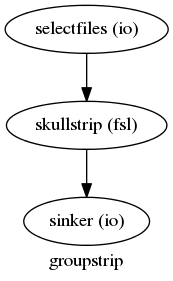

In [48]:
wf.write_graph('workflow_graph.dot')
from IPython.display import Image
Image(filename = 'workflow_graph.dot.png' )

In [47]:
from nipype import SelectFiles
templates = dict(T1="/home/iballard/fd/data/{subject_id}/anat/T1w_Whole_brain_1mm.nii.gz")
sf = SelectFiles(templates)
sf.base_dir = '.'
dg = Node(SelectFiles(templates), "selectfiles")
dg.inputs.subject_id = 'fd_101' #sub_list
print dg.outputs.get()
skullstrip = Node(fsl.BET(mask=False), name="skullstrip")

print sub_list

wf = Workflow(name = 'groupstrip')
wf.basedir = '.'
wf.connect(dg,'T1',skullstrip,'in_file')

import nipype.interfaces.io as nio

datasink = Node(nio.DataSink(), name='sinker')
datasink.inputs.base_directory = '/home/iballard/fd/data/'
wf.connect(skullstrip, 'out_file', datasink, 'container')


{'T1': <undefined>}
['fd_101', 'fd_102', 'fd_104', 'fd_105', 'fd_106', 'fd_107', 'fd_108', 'fd_109', 'fd_110', 'fd_112', 'fd_113', 'fd_114', 'fd_115', 'fd_117', 'fd_118']


INFO:workflow:Executing node datasource in dir: /tmp/tmpl6A47q/datasource
INFO:workflow:Converting dotfile: /home/iballard/workflow_graph.dot to png format



anat = /home/iballard/fd/data/fd_101/anat/T1w_Whole_brain_1mm.nii.gz
func = ['/home/iballard/fd/data/fd_101/func/loc/run_2.nii.gz', '/home/iballard/fd/data/fd_101/func/ser/run_2.nii.gz', '/home/iballard/fd/data/fd_101/func/sim/run_2.nii.gz']



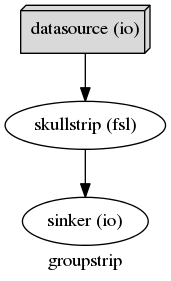

In [40]:
from nipype.pipeline.engine import Node, MapNode, Workflow
from nipype.interfaces.io import DataGrabber, DataFinder, DataSink
from nipype.interfaces import fsl
from nipype.interfaces.fsl import BET
from os.path import abspath
from IPython.display import Image

os.chdir('/home/iballard/')
skullstrip = Node(fsl.BET(mask=False), name="skullstrip")

##set up data grabber
ds = Node(DataGrabber(infields=['subject_id','task_id','run_id'],outfields =['func','anat']),
         name = 'datasource')
ds.inputs.base_directory = abspath('fd/data/')
ds.inputs.template = '*'
ds.inputs.template_args = {'func': [['subject_id','task_id','run_id']], 'anat':[['subject_id']]}
ds.inputs.field_template = {'func': '%s/func/%s/run_%s.nii.gz' ,
                      'anat': '%s/anat/T1w_Whole_brain_1mm.nii.gz'}
ds.inputs.sort_filelist = True

ds.inputs.subject_id = 'fd_101'
ds.inputs.task_id = '*'
ds.inputs.run_id = 2
ds.iterables = ('subject_id',sub_list)
print ds.run().outputs

wf = Workflow(name = 'groupstrip')
wf.basedir = abspath('fd/data/')
wf.connect(ds,'anat',skullstrip,'in_file')

##set up Data Sink
sinker = Node(DataSink(), name = 'sinker')
sinker.inputs.base_directory = abspath('output')
wf.connect(skullstrip,'out_file',sinker,'skull_stripped')

#visualize workflow
wf.write_graph('workflow_graph.dot')
Image(filename = 'workflow_graph.dot.png' )

In [41]:
wf.run(plugin = 'MultiProc')

INFO:workflow:['check', 'execution', 'logging']
INFO:workflow:Running in parallel.
INFO:workflow:Submitting 15 jobs
INFO:workflow:Executing: datasource.aI.a14 ID: 0
INFO:workflow:Executing: datasource.aI.a05 ID: 1
INFO:workflow:Executing: datasource.aI.a00 ID: 2
INFO:workflow:Executing: datasource.aI.a01 ID: 4
INFO:workflow:Executing node datasource.aI.a14 in dir: /tmp/tmpoEiq63/groupstrip/_subject_id_fd_118/datasource
INFO:workflow:Executing: datasource.aI.a08 ID: 6
INFO:workflow:Executing node datasource.aI.a05 in dir: /tmp/tmpVuZrZx/groupstrip/_subject_id_fd_107/datasource
INFO:workflow:Executing: datasource.aI.a04 ID: 7
INFO:workflow:Executing: datasource.aI.a10 ID: 10
INFO:workflow:Executing node datasource.aI.a00 in dir: /tmp/tmpi6XbgN/groupstrip/_subject_id_fd_101/datasource
INFO:workflow:Executing: datasource.aI.a03 ID: 13
INFO:workflow:Executing: datasource.aI.a07 ID: 16
INFO:workflow:Executing: datasource.aI.a12 ID: 21
INFO:workflow:Executing: datasource.aI.a02 ID: 23
INFO:wo

In [41]:
from nipype.interfaces.nipy.preprocess import FmriRealign4d
print(BET.help())


Wraps command **bet**

Use FSL BET command for skull stripping.

For complete details, see the `BET Documentation.
<http://www.fmrib.ox.ac.uk/fsl/bet2/index.html>`_

Examples
--------
>>> from nipype.interfaces import fsl
>>> from nipype.testing import  example_data
>>> btr = fsl.BET()
>>> btr.inputs.in_file = example_data('structural.nii')
>>> btr.inputs.frac = 0.7
>>> res = btr.run() # doctest: +SKIP

Inputs::

	[Mandatory]
	in_file: (an existing file name)
		input file to skull strip
		flag: %s, position: 0
	terminal_output: ('stream' or 'allatonce' or 'file' or 'none')
		Control terminal output: `stream` - displays to terminal
		immediately, `allatonce` - waits till command is finished to display
		output, `file` - writes output to file, `none` - output is ignored

	[Optional]
	args: (a string)
		Additional parameters to the command
		flag: %s
	center: (a list of at most 3 items which are an integer)
		center of gravity in voxels
		flag: -c %s
	environ: (a dictionary with keys whic